In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
import scipy.stats as stats
from ipywidgets import FloatProgress
from IPython.display import display
import requests
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
cfpTable = pd.read_csv("cfpTable.csv")


Now cfpTable contains everything we want to know about each entry

For example, let's plot the sky position of every KOI, and plot those vetted in DR25 as false positive on top

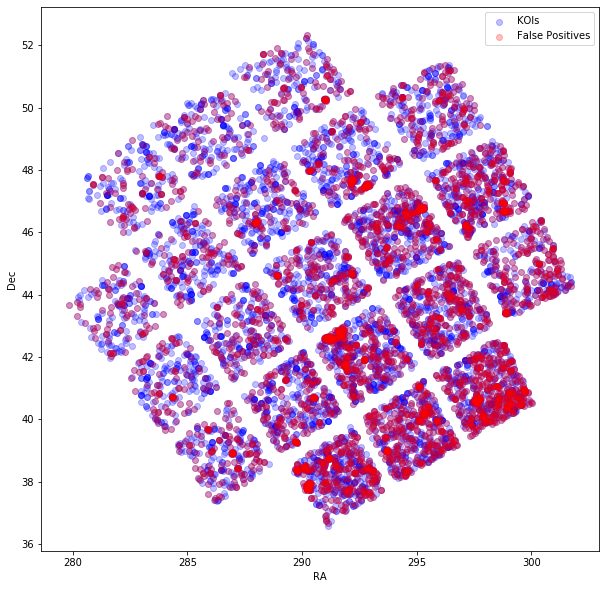

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(cfpTable.ra, cfpTable.dec, alpha=0.25, c='b')
plt.scatter(cfpTable[cfpTable.koi_pdisposition == "FALSE POSITIVE"].ra, 
            cfpTable[cfpTable.koi_pdisposition == "FALSE POSITIVE"].dec, alpha=0.25, c='r')
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend(("KOIs", "False Positives"))

Let's add Galactic coordinates

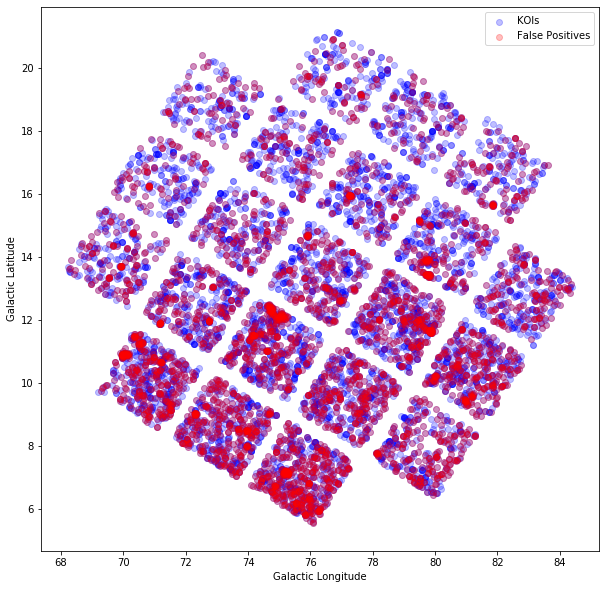

In [12]:
c = SkyCoord(ra=cfpTable.ra*u.degree, dec=cfpTable.dec*u.degree, frame='icrs')
galLong = np.array(c.galactic.l)
galLat = np.array(c.galactic.b)
cfpTable["galLong"] = galLong
cfpTable["galLat"] = galLat

plt.figure(figsize=(10,10))
plt.scatter(cfpTable.galLong, cfpTable.galLat, alpha=0.25, c='b')
plt.scatter(cfpTable[cfpTable.koi_pdisposition == "FALSE POSITIVE"].galLong, 
            cfpTable[cfpTable.koi_pdisposition == "FALSE POSITIVE"].galLat, alpha=0.25, c='r')
plt.xlabel("Galactic Longitude")
plt.ylabel("Galactic Latitude")
plt.legend(("KOIs", "False Positives"))

Now restrict ourselves to false positives with an identified offset in DR25

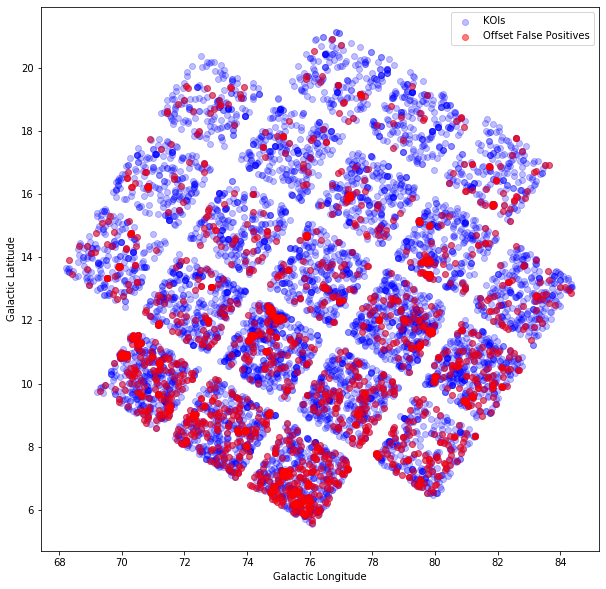

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(cfpTable.galLong, cfpTable.galLat, alpha=0.25, c='b')
plt.scatter(cfpTable[cfpTable.koi_fpflag_co == 1].galLong, 
            cfpTable[cfpTable.koi_fpflag_co == 1].galLat, alpha=0.5, c='r')
plt.xlabel("Galactic Longitude")
plt.ylabel("Galactic Latitude")
plt.legend(("KOIs", "Offset False Positives"))

Now let's compare to the certified FP results.  Restrict the cfpTable to objects that have been examined, and look for those that have the certified offset flag.

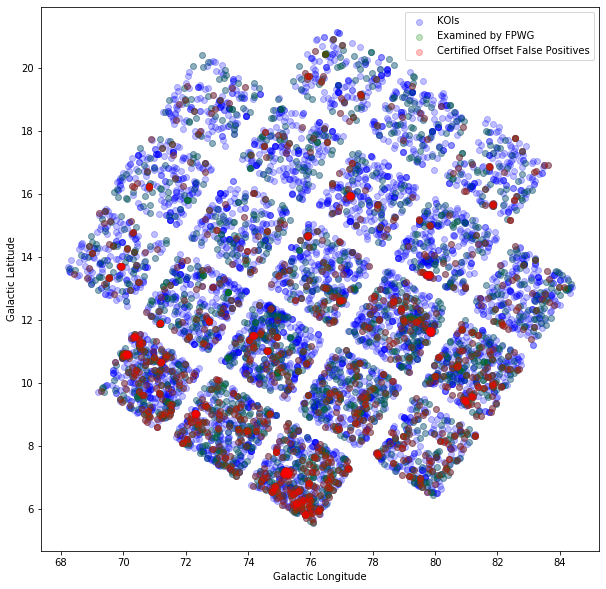

In [13]:
cfpTableExamined = cfpTable[cfpTable.fpwg_disp_status != "NOT EXAMINED"];
plt.figure(figsize=(10,10))
plt.scatter(cfpTable.galLong, cfpTable.galLat, alpha=0.25, c='b')
plt.scatter(cfpTableExamined.galLong, cfpTableExamined.galLat, alpha=0.25, c='g')
plt.scatter(cfpTableExamined[cfpTableExamined.fpwg_disp_offst == 1].galLong, 
            cfpTableExamined[cfpTableExamined.fpwg_disp_offst == 1].galLat, alpha=0.25, c='r')
plt.xlabel("Galactic Longitude")
plt.ylabel("Galactic Latitude")
plt.legend(("KOIs", "Examined by FPWG", "Certified Offset False Positives"))

It looks like the fraction of offset false positives depends on Galactic latitude. 
Let's look at that fraction as a function of Galactic latitude, by counting the number of KOIs and certified offsets in 10 bins of Galactic Latitude.

In [59]:
minLatitude = min(cfpTable.galLat)
maxLatitude = max(cfpTable.galLat)

nBins = 10
latRange = np.linspace(minLatitude, maxLatitude, nBins)
nKois = np.zeros(len(latRange)-1);
nOffsetFps = np.zeros(len(latRange)-1);
offsetFraction = np.zeros(len(latRange)-1);
binGalLat = np.zeros(len(latRange)-1);

for l in range(len(latRange)-1):
    binGalLat[l] = (latRange[l] + latRange[l+1])/2
    nKois[l] = sum((cfpTable.galLat > latRange[l]) & (cfpTable.galLat <= latRange[l+1]));
    nOffsetFps[l] = sum((cfpTable[cfpTable.fpwg_disp_offst == 1].galLat > latRange[l]) 
                        & (cfpTable[cfpTable.fpwg_disp_offst == 1].galLat <= latRange[l+1]));
    offsetFraction[l] = nOffsetFps[l]/nKois[l];

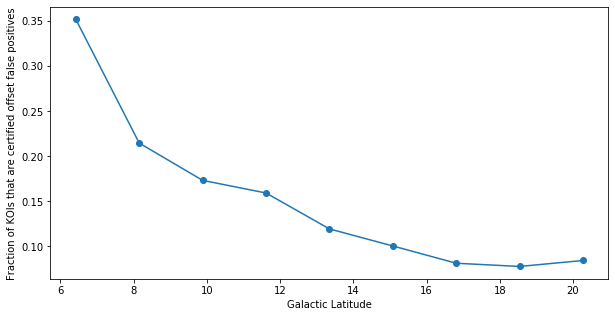

In [61]:
plt.figure(figsize=(10,5));
plt.plot(binGalLat, offsetFraction, 'o-');
plt.xlabel("Galactic Latitude");
plt.ylabel("Fraction of KOIs that are certified offset false positives");

Now look at offsets in DR25 that were examined but not certified by the FPWG

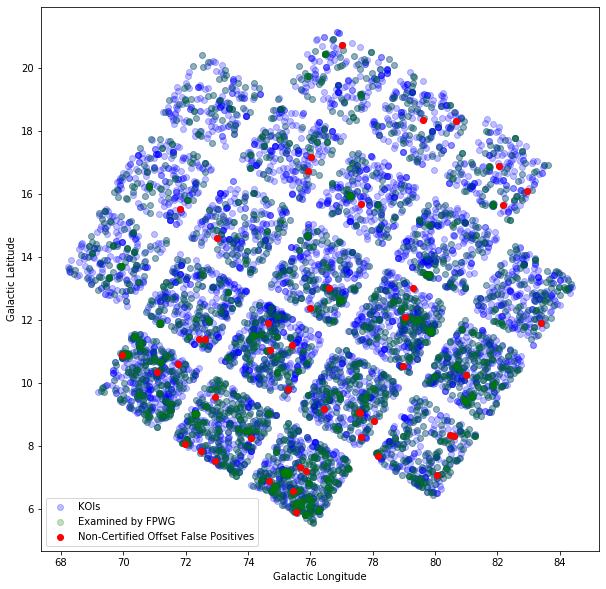

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(cfpTable.galLong, cfpTable.galLat, alpha=0.25, c='b')
plt.scatter(cfpTableExamined.galLong, cfpTableExamined.galLat, alpha=0.25, c='g')
plt.scatter(cfpTableExamined[(cfpTableExamined.fpwg_disp_offst == 0)&(cfpTableExamined.koi_fpflag_co == 1)].galLong, 
            cfpTableExamined[(cfpTableExamined.fpwg_disp_offst == 0)&(cfpTableExamined.koi_fpflag_co == 1)].galLat, 
            alpha=1, c='r')
plt.xlabel("Galactic Longitude");
plt.ylabel("Galactic Latitude");
plt.legend(("KOIs", "Examined by FPWG", "Non-Certified Offset False Positives"));

What about DR25 false positives that the FPWG says are possible planets?

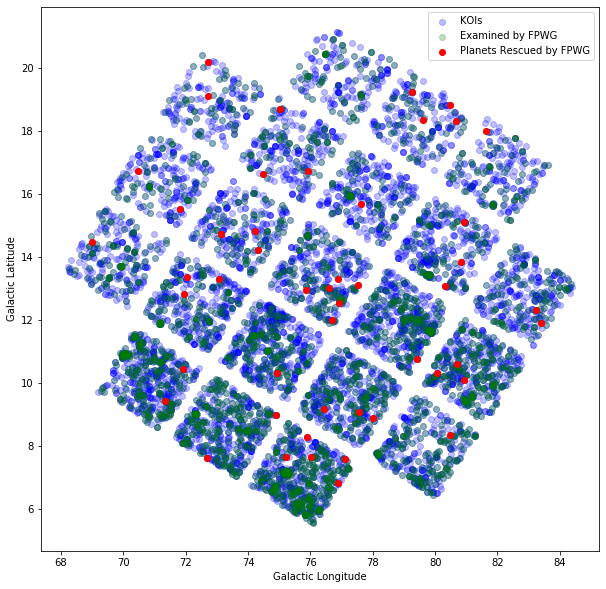

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(cfpTable.galLong, cfpTable.galLat, alpha=0.25, c='b')
plt.scatter(cfpTableExamined.galLong, cfpTableExamined.galLat, alpha=0.25, c='g')
plt.scatter(cfpTableExamined[(cfpTableExamined.fpwg_disp_status == "POSSIBLE PLANET")
                             &(cfpTableExamined.koi_pdisposition == "FALSE POSITIVE")].galLong, 
            cfpTableExamined[(cfpTableExamined.fpwg_disp_status == "POSSIBLE PLANET")
                             &(cfpTableExamined.koi_pdisposition == "FALSE POSITIVE")].galLat, 
            alpha=1, c='r')
plt.xlabel("Galactic Longitude");
plt.ylabel("Galactic Latitude");
plt.legend(("KOIs", "Examined by FPWG", "Planets Rescued by FPWG"));